In [299]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
import matplotlib as mpl
from numpy import concatenate as cat
from collections import defaultdict
from sklearn import metrics
mpl.rcParams['figure.dpi'] = 250

PATHS = [sorted(glob.glob(f'results/csi/seed_{i}/*.pkl')) for i in range(1, 7)]

In [300]:
def plott(model_name, sens, spec, ppv, ax):
    if 'pecarn' in model_name.lower():
        ax.plot(sens[0], spec[0], '.-', label=model_name)
    else:
        ax.plot(sens, spec, '.-', label=model_name)

In [301]:
def multiplot(paths, ax, suffix=""):
    for model_file in paths:
        basename = os.path.basename(model_file).split('.')[0]
        if (suffix != '' and suffix in model_file) or (suffix == '' and '_' not in basename):
            dct = pkl.load(open(model_file, 'rb'))
            plott(basename, dct['sens_tune'], dct['spec_tune'], dct['ppv_tune'], ax)
    ax.legend(frameon=False, loc='best')
    ax.set_xlim(0.5, 1.05)
    # ax.set_ylim(0, 0.2)

In [302]:
def multiseedplot(suffix=""):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for i in range(1, 7):
        multiplot(PATHS[i-1], axes[(i-1) // 3, (i-1) % 3], suffix)
    plt.xlabel('sens')
    plt.ylabel('spec')
    plt.tight_layout()

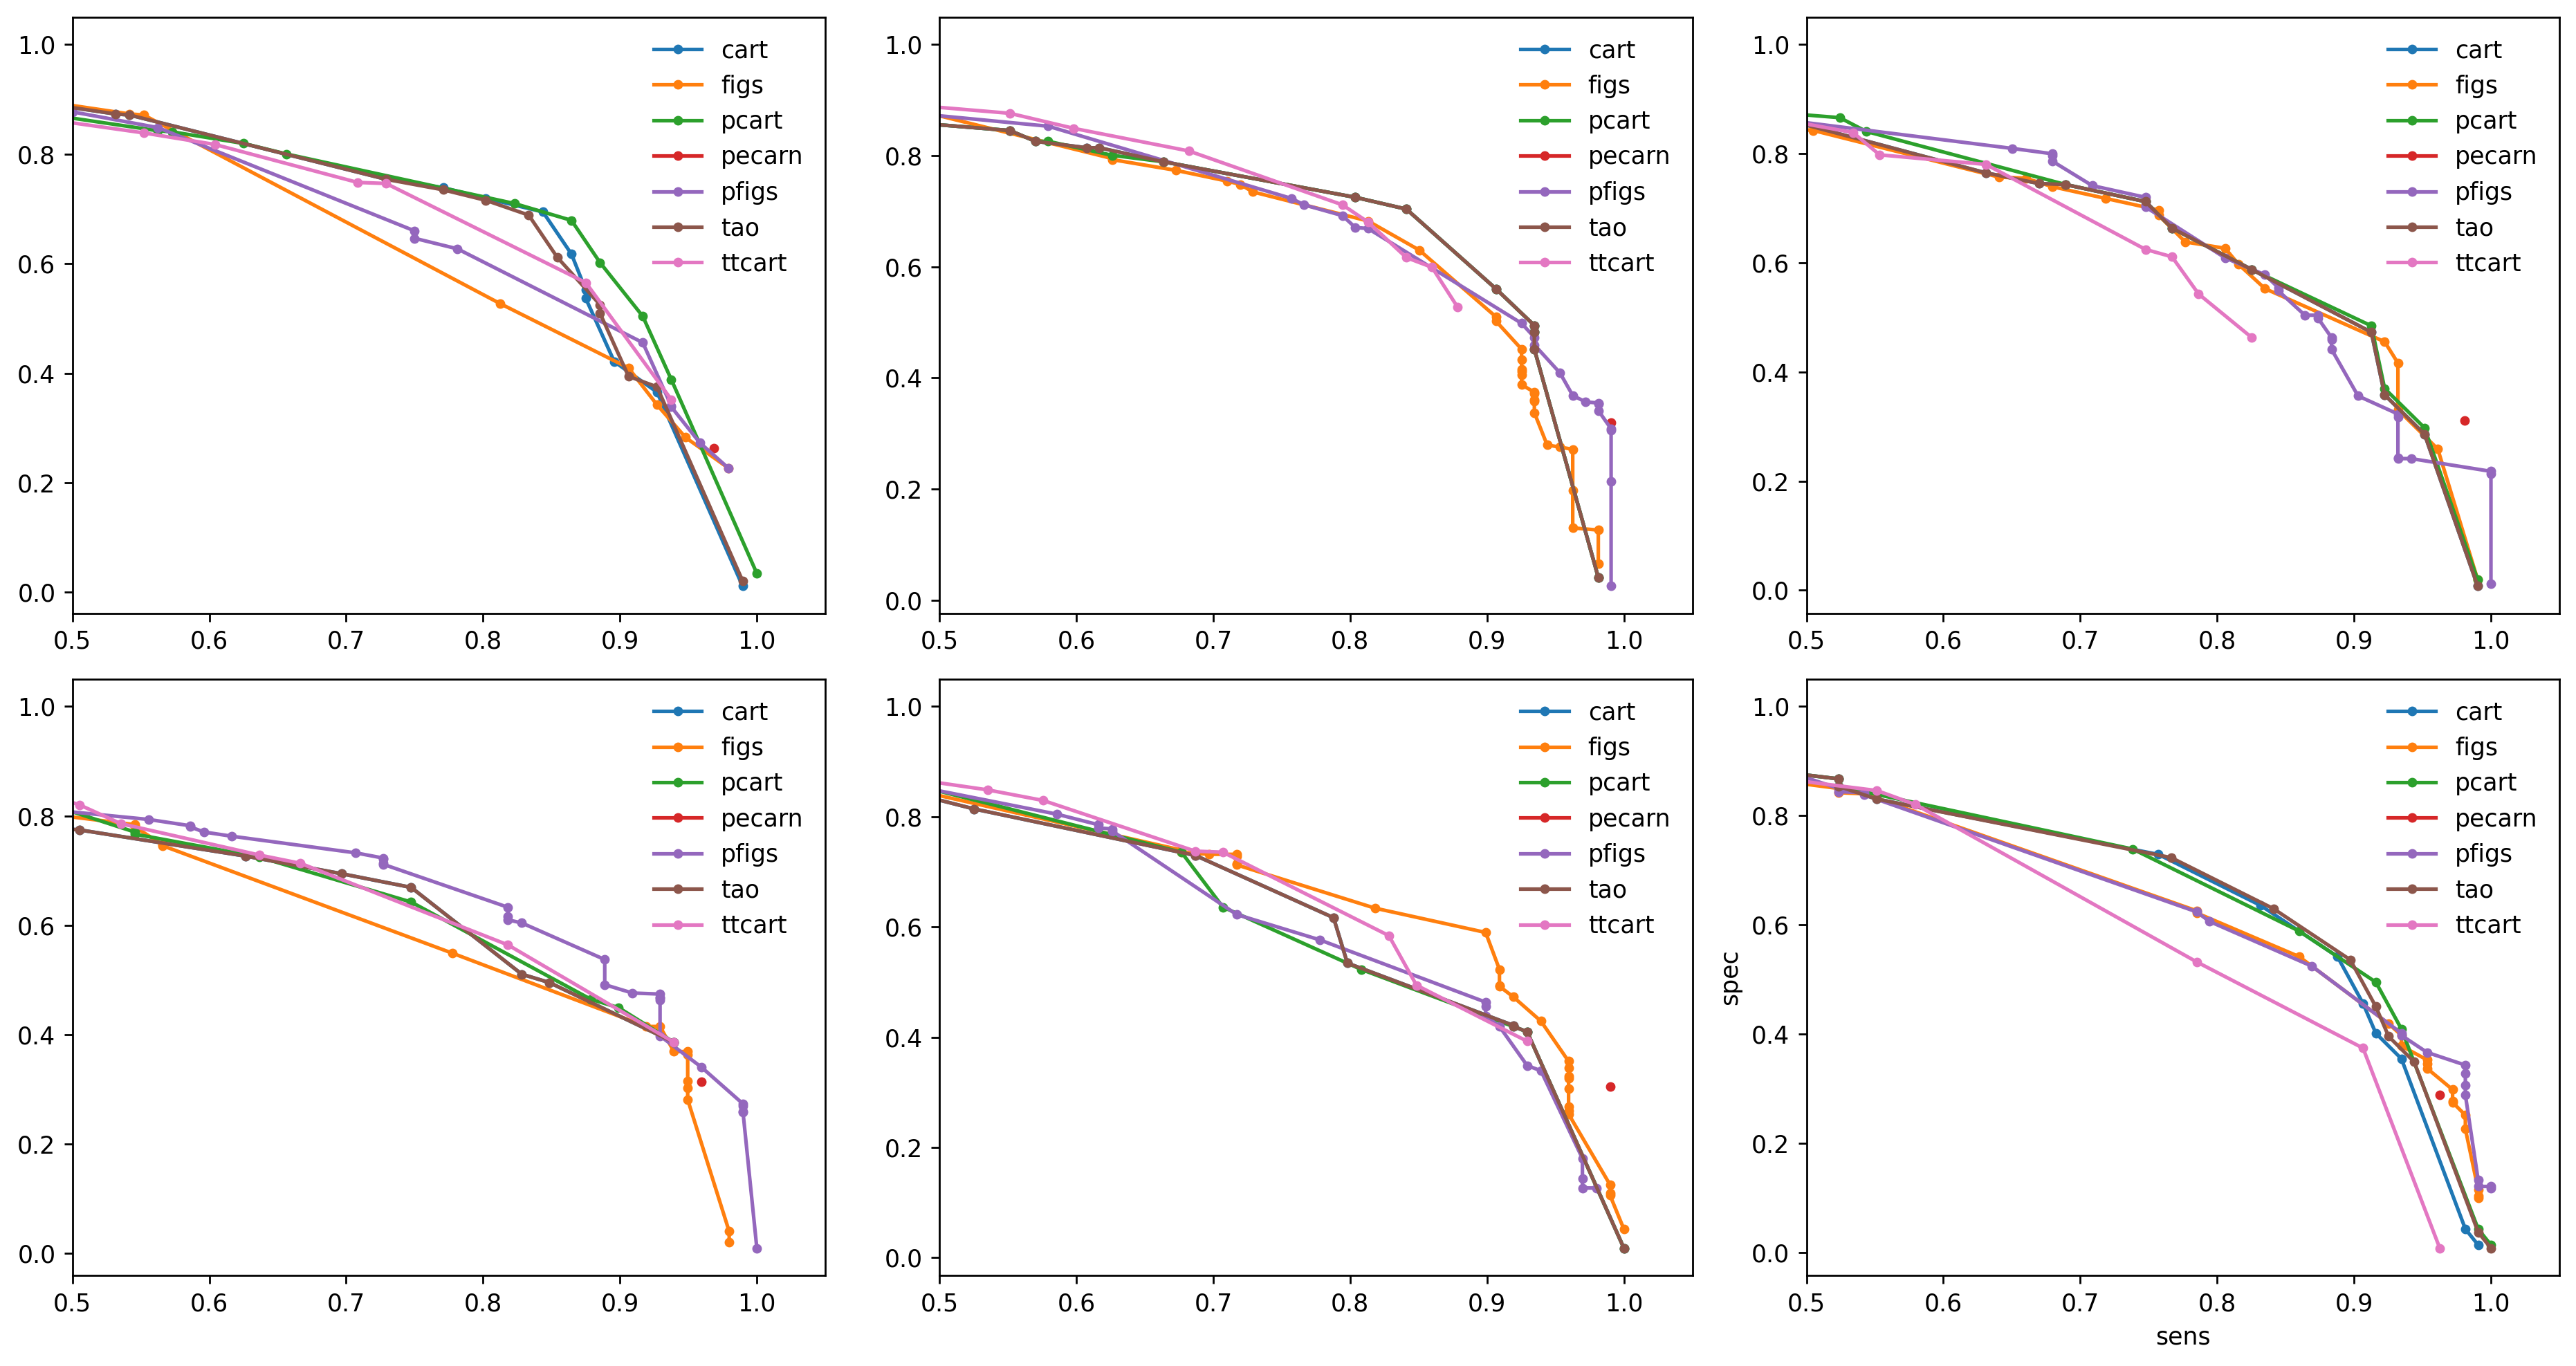

In [303]:
multiseedplot()

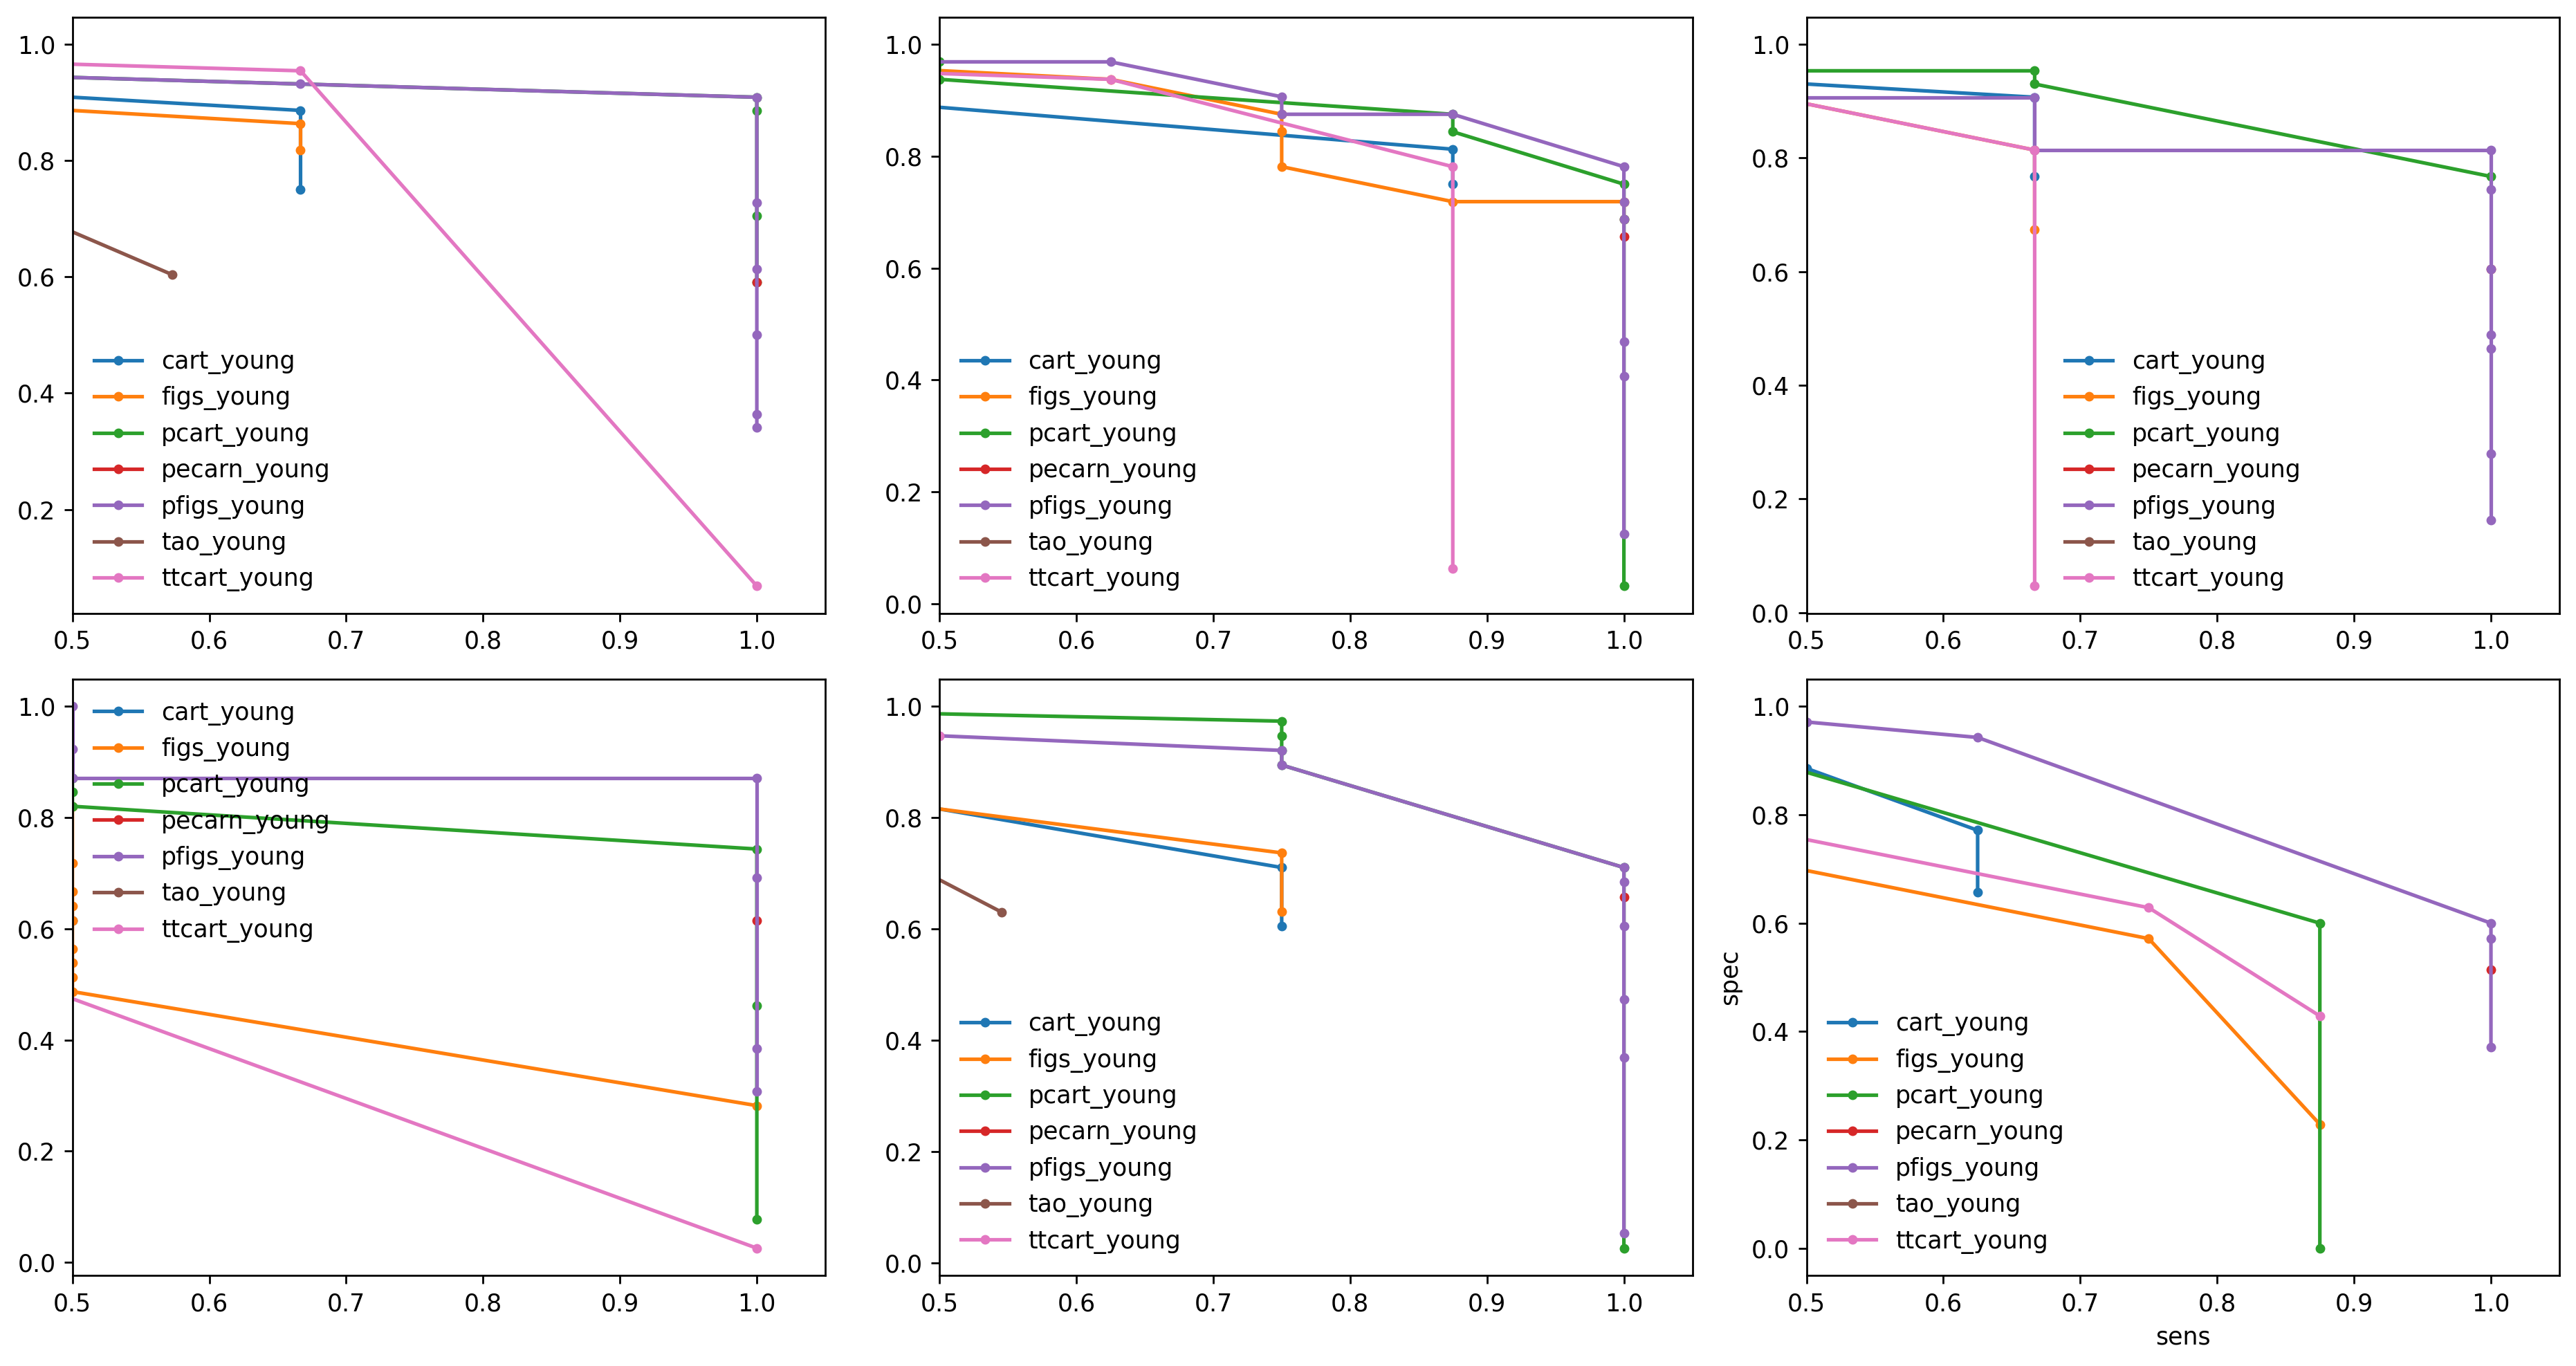

In [304]:
multiseedplot(suffix='_young')

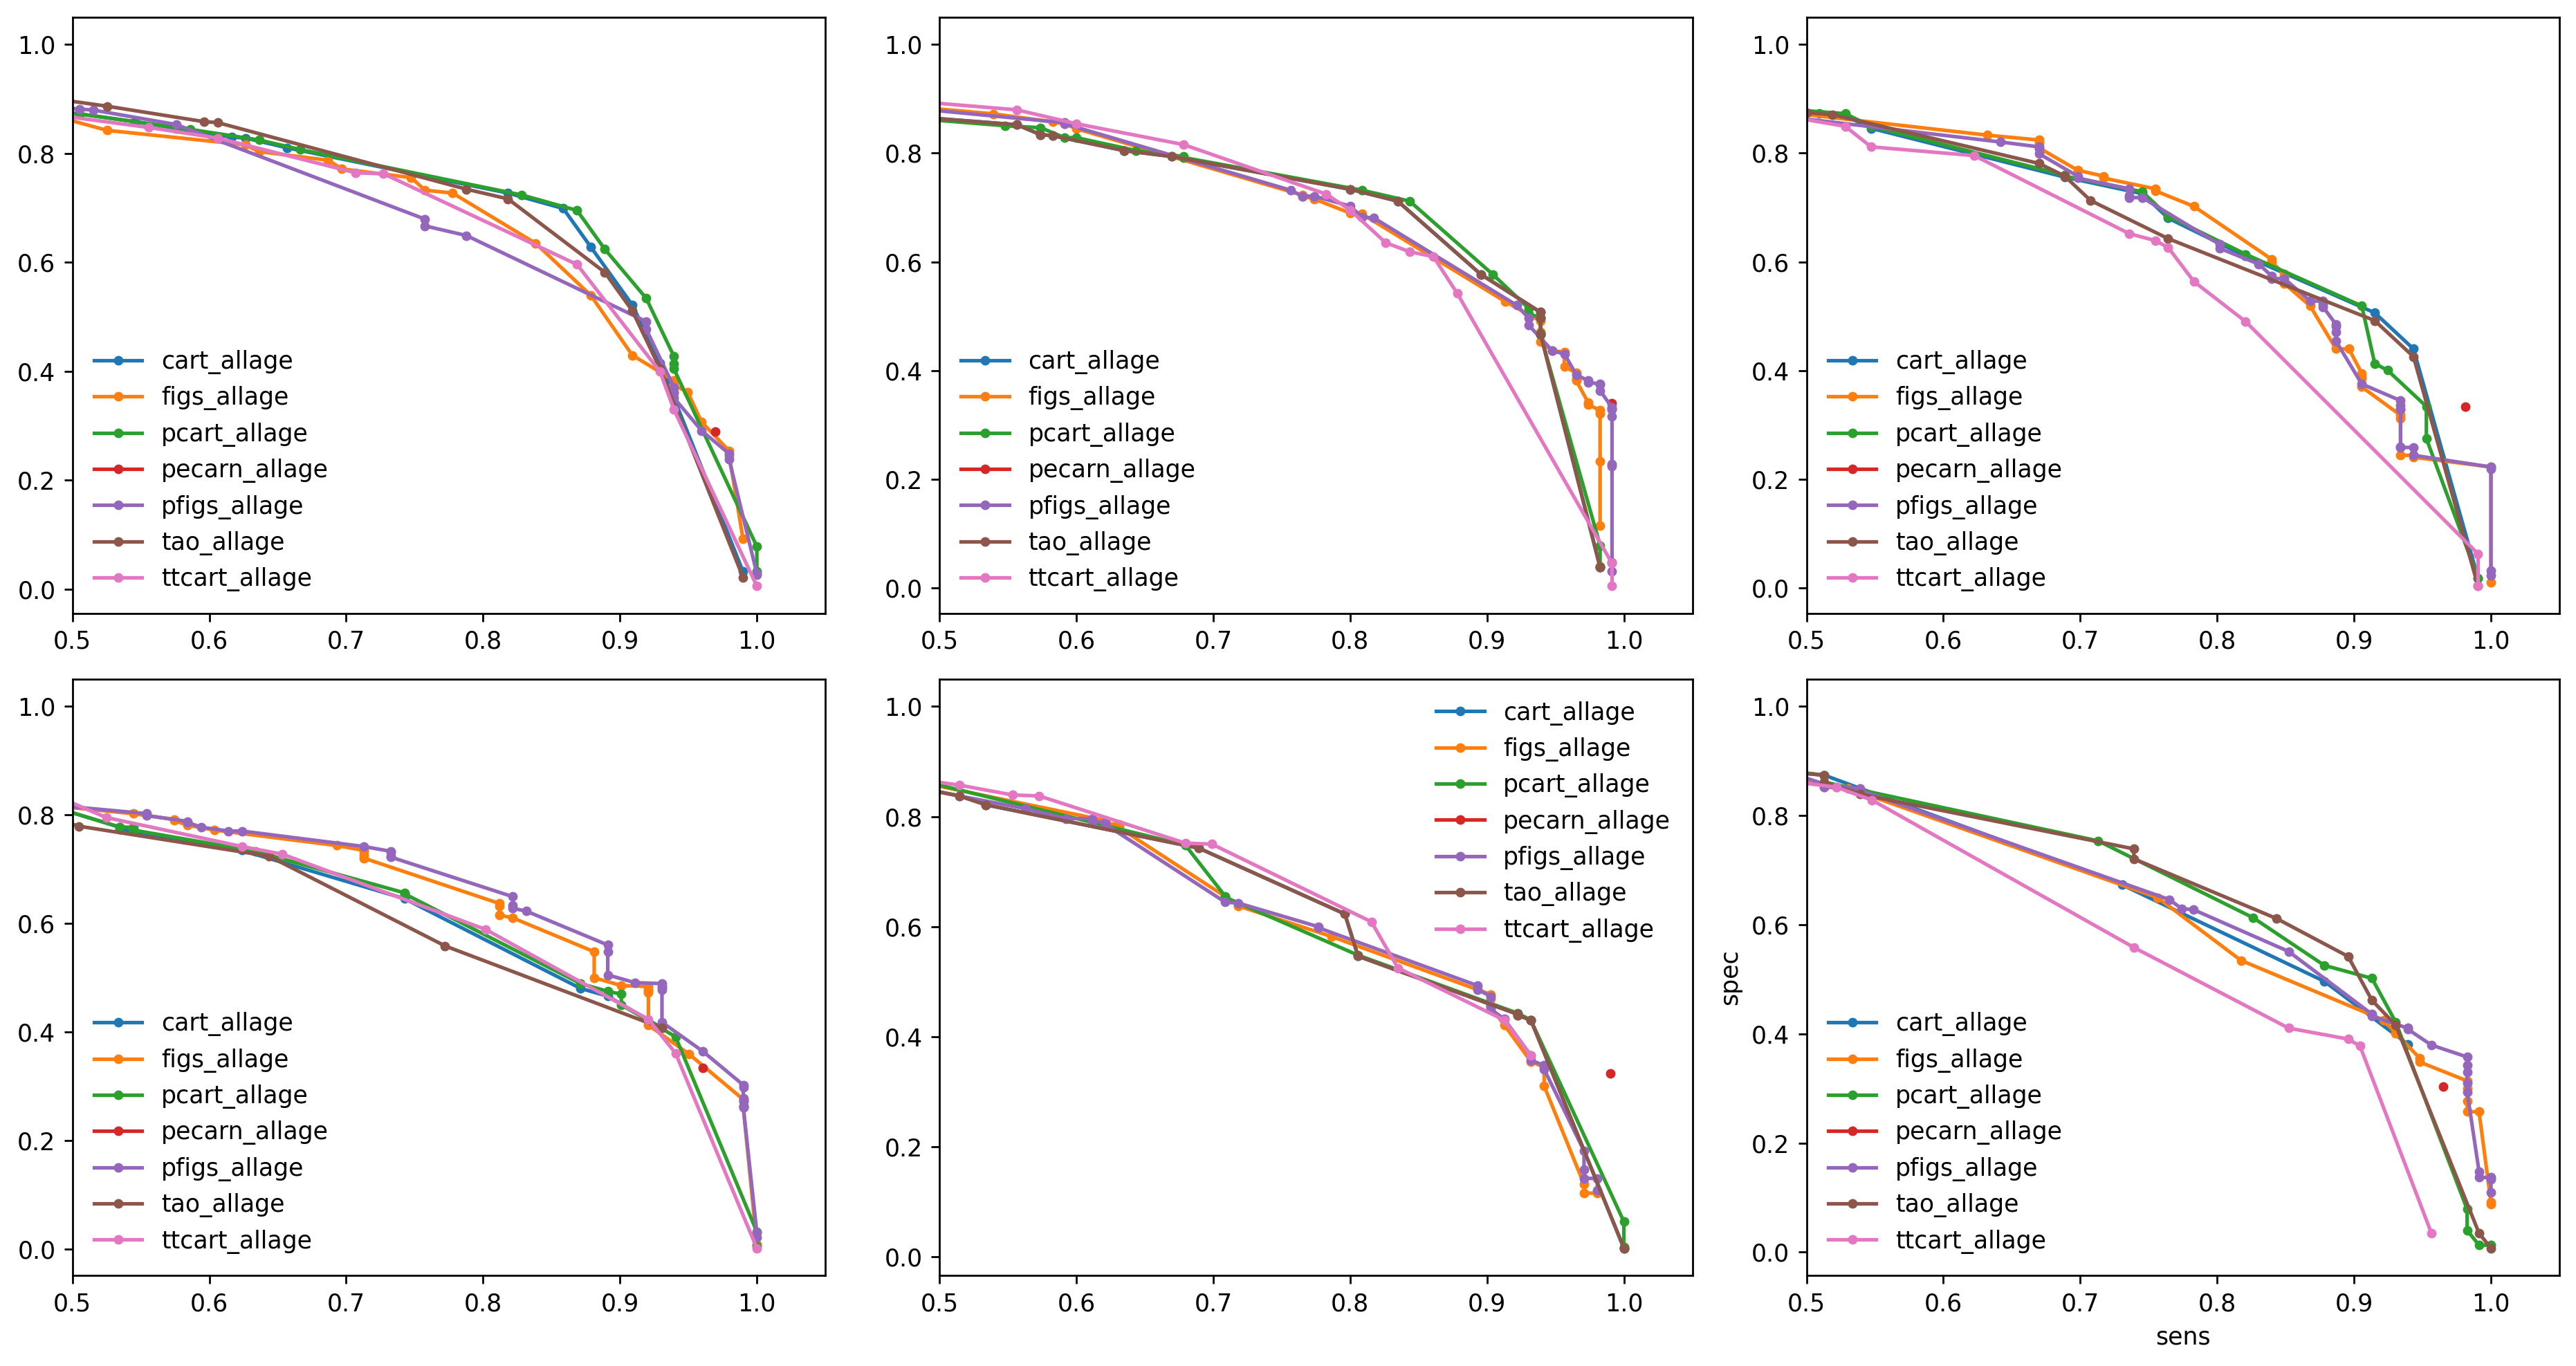

In [305]:
multiseedplot(suffix='_allage')

In [306]:
sens_levels = [0.94, 0.96, 0.98]

In [307]:
table = defaultdict(lambda:[])
table_index = [os.path.basename(f).split('.')[0] for f in PATHS[0]]

In [308]:
for i, seed_paths in enumerate(PATHS):
    for model_file in seed_paths:
        if 'ptao' in model_file:
            continue
        dct = pkl.load(open(model_file, 'rb'))
        specs = np.array(dct['spec_tune'])
        senses = np.array(dct['sens_tune'])
        precisions = np.array(dct['ppv_tune'])
        for sens in sens_levels:
            table[f'spec_{sens}_seed_{i}'].append(
                np.max(specs[senses > sens]) if specs[senses > sens].shape[0] > 0 else 0.0)
        table[f'auc_seed_{i}'].append(metrics.auc(1 - specs, senses))
        # table[f'auprc_seed_{i}'].append(metrics.auc(senses, np.nan_to_num(precisions, nan=1)))
        table[f'aps_seed_{i}'].append(-np.sum(np.diff(senses) * np.array(precisions)[:-1]))

In [309]:
res_table = pd.DataFrame(table, index=table_index)

for i, seed_paths in enumerate(PATHS):
    for metric in ['spec_0.94', 'spec_0.96', 'spec_0.98', 'auc', 'aps']:
        res_table_metric = res_table.loc[:, res_table.columns.str.contains(metric)]
        res_table[metric] = res_table_metric.mean(axis=1)

    for metric in ['spec_0.94', 'spec_0.96', 'spec_0.98', 'auc', 'aps']:
        res_table_metric = res_table.loc[:, res_table.columns.str.contains(metric)]
        res_table[f'{metric}_std'] = res_table_metric.std(axis=1)

In [314]:
# res_table.to_csv('results/csi/csi_final.csv')

In [311]:
res_table[~res_table.index.str.contains('young') & ~res_table.index.str.contains('allage')].iloc[:, -10:-5].style.background_gradient()

,spec_0.94,spec_0.96,spec_0.98,auc,aps
cart,0.070118,0.019324,0.019324,0.629193,0.321002
figs,0.283956,0.188565,0.087693,0.619060,0.324958
pcart,0.075400,0.024205,0.024205,0.627857,0.327002
pecarn,0.269430,0.229704,0.155249,0.304618,0.188034
pfigs,0.272977,0.242629,0.189571,0.623630,0.339020
tao,0.120793,0.019660,0.019660,0.629362,0.321298
ttcart,0.001505,0.001505,0.000000,0.393141,0.333842


In [312]:
res_table[res_table.index.str.contains('young')].iloc[:, -10:-5].style.background_gradient()

,spec_0.94,spec_0.96,spec_0.98,auc,aps
cart_young,0.000000,0.000000,0.000000,0.115946,0.229568
figs_young,0.178586,0.178586,0.178586,0.213536,0.246673
pcart_young,0.597203,0.597203,0.597203,0.592458,0.468312
pecarn_young,0.542904,0.542904,0.542904,0.176378,0.213764
pfigs_young,0.700649,0.700649,0.700649,0.622413,0.469950
tao_young,0.000000,0.000000,0.000000,0.086655,0.110350
ttcart_young,0.016772,0.016772,0.016772,0.447414,0.282136


In [313]:
res_table[res_table.index.str.contains('allage')].iloc[:, -10:-5].style.background_gradient()

,spec_0.94,spec_0.96,spec_0.98,auc,aps
cart_allage,0.096300,0.016818,0.016818,0.578074,0.321046
figs_allage,0.314730,0.241369,0.206169,0.641185,0.340923
pcart_allage,0.164599,0.053503,0.053503,0.685893,0.337707
pecarn_allage,0.288296,0.288296,0.166111,0.295702,0.189020
pfigs_allage,0.311293,0.268280,0.221563,0.656662,0.340762
tao_allage,0.096668,0.018191,0.018191,0.634713,0.325089
ttcart_allage,0.089477,0.019859,0.019859,0.632311,0.338143
